In [1]:
import sys
import numpy as np
import pandas as pd
import os
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch
sys.path.append("../../../data_pipeline")
sys.path.append("../..")
sys.path.append("..")

from utils import train_test_split, create_metadata_df
from dataset_xy import CARLADatasetXY
from dataset_xy_opt import CARLADatasetXYOpt
from data_preprocessing import preprocessing

from baseline_v1 import Baseline_V1
from baseline_v2 import Baseline_V2
from baseline_v3 import Baseline_V3

from model_trainer import ModelTrainer

/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create Dataset and DataLoader

In [4]:
path_data = os.path.join("..", "..", "..", "data", "data")
# path_data = os.path.join("..", "..", "..", "data", "data_prep")

config_xy = {"used_inputs": ["rgb", "measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "y": ["brake", "steer", "throttle"],
        "seq_len": 1
        }

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps' if torch.has_mps else 'cpu')
batch_size = 64

# Create df_meta 
df_meta_data = create_metadata_df(path_data, config_xy["used_inputs"])
df_meta_data_train, df_meta_data_test = train_test_split(df_meta_data, towns={"train": ["Town04"], "test": ["Town05"]}) # "Town06"
# Make test set the 15% of the size of the train set
df_meta_data_test = df_meta_data_test.sample(n=int(df_meta_data_train.shape[0] * 0.15), random_state=3)

# df_meta_data_train = df_meta_data # test whole set for nan values
# df_meta_data_test = df_meta_data.sample(n=int(df_meta_data_train.shape[0] * 0.15), random_state=3)
# df_meta_data_train = df_meta_data_train.head(5 * batch_size)
# df_meta_data_test = df_meta_data_test.sample(n=int(df_meta_data_train.shape[0] * 0.15), random_state=3)

# Create Dataset & DataLoader
dataset_train = CARLADatasetXY(root_dir=path_data, df_meta_data=df_meta_data_train, config=config_xy)
dataset_test = CARLADatasetXY(root_dir=path_data, df_meta_data=df_meta_data_test, config=config_xy)
# dataset_train.x_sample.to(device)
# dataset_train.y_sample.to(device)
# dataset_test.x_sample.to(device)
# dataset_test.y_sample.to(device)
dataset_train = CARLADatasetXYOpt(df_meta_data_train)
dataset_test = CARLADatasetXYOpt(df_meta_data_test)

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=0, shuffle=True, collate_fn=lambda x: list(map(lambda x: x.to(device), default_collate(x))))
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, num_workers=0, shuffle=False, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
# collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x))

Varying number files among input types: ../../../data/data/cycl_dataset_23_11/Routes_non-straight-junction-Scen4_Town03_junction_Seed2000/non-straight-junction-Scen4_Town03_junction_route96_11_24_08_12_53/lidar_prep
Varying number files among input types: ../../../data/data/cycl_dataset_23_11/Routes_non-straight-junction-Scen4_Town03_junction_Seed2000/non-straight-junction-Scen4_Town03_junction_route114_11_24_11_14_46/lidar_prep
Varying number files among input types: ../../../data/data/cycl_dataset_23_11/Routes_non-straight-junction-Scen4_Town03_junction_Seed2000/non-straight-junction-Scen4_Town03_junction_route46_11_24_01_45_35/lidar_prep
Varying number files among input types: ../../../data/data/cycl_dataset_23_11/Routes_non-straight-junction-Scen4_Town03_junction_Seed2000/non-straight-junction-Scen4_Town03_junction_route0_11_23_20_09_07/lidar_prep
Varying number files among input types: ../../../data/data/cycl_dataset_23_11/Routes_non-straight-junction-Scen4_Town03_junction_Seed200

In [4]:
df_meta_data.isna().sum()

dir               0
rgb             114
measurements    114
dtype: int64

In [7]:
df_meta_data[df_meta_data.isna().any(axis=1)]["dir"].unique()

array(['../../../data/data/cycl_dataset_23_11/Routes_non-straight-junction-Scen4_Town03_junction_Seed2000/non-straight-junction-Scen4_Town03_junction_route75_11_24_05_19_27'],
      dtype=object)

In [12]:
path = "/Users/julianvonklitzing/Documents/GitHub/end2endappras/data/data/cycl_dataset_23_11/Routes_non-straight-junction-Scen4_Town03_junction_Seed2000/non-straight-junction-Scen4_Town03_junction_route75_11_24_05_19_27/rgb_prep"
len(os.listdir(path))

114

In [11]:
len(dataloader_train)

952

In [12]:
len(dataloader_test)

143

# Create ModelTrainer & run it

In [13]:
model = Baseline_V3()
#model.load_state_dict(torch.load("Baseline_V1_6_hours.pt"))

/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
# see fix for multiple inputs: https://github.com/sksq96/pytorch-summary/issues/90
# summary(model, input_size=[(3, 160, 960), (7,), (1,)], batch_size=32)

In [15]:
model_trainer = ModelTrainer(
    model=model,
    optimizer=optim.Adam(model.parameters(), lr=0.0001),
    loss_fn=nn.L1Loss(),
    n_epochs=10,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    preprocessing=preprocessing,
    upload_tensorboard=True
    )

Model will be trained on: mps


In [16]:
model_trainer.run()

Epoch 1



AttributeError: 'dict' object has no attribute 'to'

# Investigating model predictions (errors)
To be moved in an extra module at some time ...

In [10]:
y_true_list, y_pred_list = model_trainer.get_dataset_predictions()

143it [02:14,  1.06it/s]


In [25]:
df_true = pd.DataFrame(np.transpose(y_true_list), columns=dataset_test.y)
df_pred = pd.DataFrame(np.transpose(y_pred_list), columns=dataset_test.y)

array([[<AxesSubplot: title={'center': 'brake'}>,
        <AxesSubplot: title={'center': 'steer'}>],
       [<AxesSubplot: title={'center': 'throttle'}>, <AxesSubplot: >]],
      dtype=object)

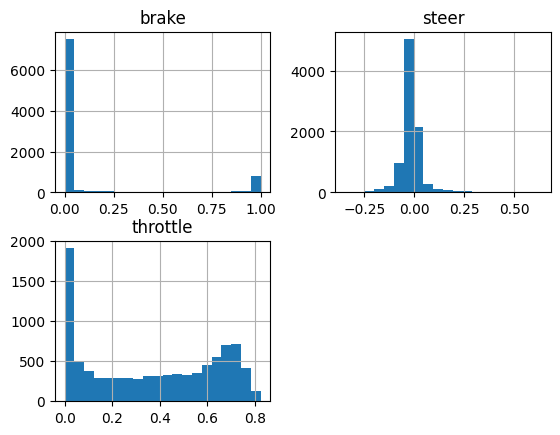

In [29]:
df_pred.hist(bins=20)

In [30]:
df_residuals = df_true - df_pred

array([[<AxesSubplot: title={'center': 'brake'}>,
        <AxesSubplot: title={'center': 'steer'}>],
       [<AxesSubplot: title={'center': 'throttle'}>, <AxesSubplot: >]],
      dtype=object)

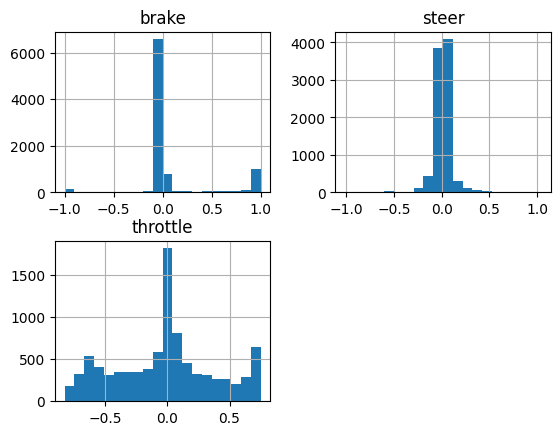

In [33]:
df_residuals.hist(bins=20)